<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_1_single_layer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Single Layer LSTM

So far in this course, you've been using mostly basic dense layers and embeddings to build your models. It detects how the combination of words (or subwords) in the input text determines the output class. In the labs this week, you will look at other layers you can use to build your models. Most of these will deal with *Recurrent Neural Networks*, a kind of model that takes the ordering of inputs into account. This makes it suitable for different applications such as parts-of-speech tagging, music composition, language translation, and the like. For example, you may want your model to differentiate sentiments even if the words used in two sentences are the same:

```
1: My friends do like the movie but I don't. --> negative review
2: My friends don't like the movie but I do. --> positive review
```

The first layer you will be looking at is the [*LSTM (Long Short-Term Memory)*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). In a nutshell, it computes the state of a current timestep and passes it on to the next timesteps where this state is also updated. The process repeats until the final timestep where the output computation is affected by all previous states. Not only that, it can be configured to be bidirectional so you can get the relationship of later words to earlier ones. If you want to go in-depth of how these processes work, you can look at the [Sequence Models](https://www.coursera.org/learn/nlp-sequence-models) course of the Deep Learning Specialization. For this lab, you can take advantage of Tensorflow's APIs that implements the complexities of these layers for you. This makes it easy to just plug it in to your model. Let's see how to do that in the next sections below.

## Download the dataset

For this lab, you will use the `subwords8k` pre-tokenized [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews). You will load it via Tensorflow Datasets as you've done last week:

In [1]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete19Z41F/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete19Z41F/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete19Z41F/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


## Prepare the dataset

You can then get the train and test splits and generate padded batches.

*Note: To make the training go faster in this lab, you will increase the batch size that Laurence used in the lecture. In particular, you will use `256` and this takes roughly a minute to train per epoch. In the video, Laurence used `16` which takes around 4 minutes per epoch.*

In [2]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'],

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

## Build and compile the model

Now you will build the model. You will simply swap the `Flatten` or `GlobalAveragePooling1D` from before with an `LSTM` layer. Moreover, you will nest it inside a [Biderectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) layer so the passing of the sequence information goes both forwards and backwards. These additional computations will naturally make the training go slower than the models you built last week. You should take this into account when using RNNs in your own applications.

In [3]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
lstm_dim = 64
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598209 (2.28 MB)
Trainable params: 598209 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

Now you can start training. Using the default parameters above, you should reach around 98% training accuracy and 82% validation accuracy. You can visualize the results using the same plot utilities. See if you can still improve on this by modifying the hyperparameters or by training with more epochs.

In [5]:
NUM_EPOCHS = 10

history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 49s 395ms/step - loss: 0.6537 - accuracy: 0.6159 - val_loss: 0.5962 - val_accuracy: 0.6790
Epoch 2/10
98/98 [==============================] - 30s 299ms/step - loss: 0.4040 - accuracy: 0.8248 - val_loss: 0.3847 - val_accuracy: 0.8468
Epoch 3/10
98/98 [==============================] - 25s 252ms/step - loss: 0.2911 - accuracy: 0.8862 - val_loss: 0.4107 - val_accuracy: 0.8226
Epoch 4/10
98/98 [==============================] - 25s 254ms/step - loss: 0.2315 - accuracy: 0.9132 - val_loss: 0.4069 - val_accuracy: 0.8419
Epoch 5/10
98/98 [==============================] - 24s 242ms/step - loss: 0.1814 - accuracy: 0.9369 - val_loss: 0.4168 - val_accuracy: 0.8403
Epoch 6/10
98/98 [==============================] - 23s 230ms/step - loss: 0.1613 - accuracy: 0.9440 - val_loss: 0.4713 - val_accuracy: 0.8032
Epoch 7/10
98/98 [==============================] - 22s 226ms/step - loss: 0.1344 - accuracy: 0.9530 - val_loss: 0.5150 - val_accuracy: 0.8373

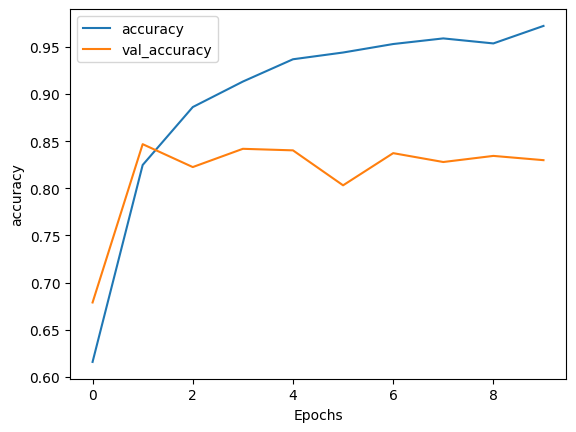

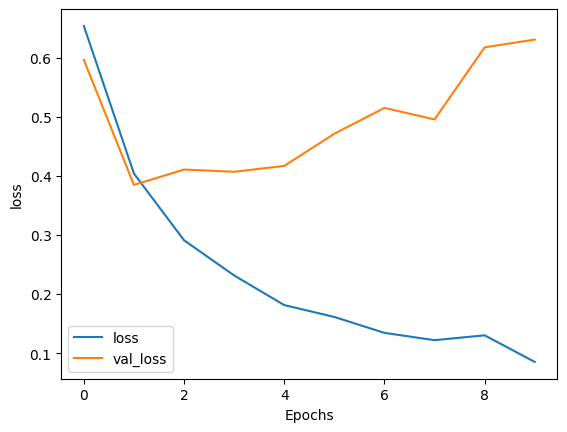

In [6]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Wrap Up

In this lab, you got a first look at using LSTM layers to build Recurrent Neural Networks. You only used a single LSTM layer but this can be stacked as well to build deeper networks. You will see how to do that in the next lab.

# Ungraded Lab: Multiple LSTMs

> Add blockquote



In this lab, you will look at how to build a model with multiple LSTM layers. Since you know the preceding steps already (e.g. downloading datasets, preparing the data, etc.), we won't expound on it anymore so you can just focus on the model building code.

## Build and Compile the Model

You can build multiple layer LSTM models by simply appending another `LSTM` layer in your `Sequential` model and enabling the `return_sequences` flag to `True`. This is because an `LSTM` layer expects a sequence input so if the previous layer is also an LSTM, then it should output a sequence as well. See the code cell below that demonstrates this flag in action. You'll notice that the output dimension is in 3 dimensions `(batch_size, timesteps, features)` when when `return_sequences` is True.

In [7]:
import tensorflow as tf
import numpy as np

# Hyperparameters
batch_size = 1
timesteps = 20
features = 16
lstm_dim = 8

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'lstm output units: {lstm_dim}')

# Define array input with random values
random_input = np.random.rand(batch_size,timesteps,features)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(lstm_dim)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(lstm_dim, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


The next cell implements the stacked LSTM architecture.

In [8]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635329 (2.42 MB)
Trainable params: 63532

In [9]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the Model

The additional LSTM layer will lengthen the training time compared to the previous lab. Given the default parameters we set, it will take around 2 minutes per epoch with the Colab GPU enabled.

In [10]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 54s 472ms/step - loss: 0.5678 - accuracy: 0.6858 - val_loss: 0.4143 - val_accuracy: 0.8182
Epoch 2/10
98/98 [==============================] - 43s 433ms/step - loss: 0.3338 - accuracy: 0.8682 - val_loss: 0.3989 - val_accuracy: 0.8404
Epoch 3/10
98/98 [==============================] - 43s 439ms/step - loss: 0.2772 - accuracy: 0.8936 - val_loss: 0.3887 - val_accuracy: 0.8400
Epoch 4/10
98/98 [==============================] - 41s 417ms/step - loss: 0.2112 - accuracy: 0.9230 - val_loss: 0.4113 - val_accuracy: 0.8422
Epoch 5/10
98/98 [==============================] - 41s 423ms/step - loss: 0.1648 - accuracy: 0.9428 - val_loss: 0.4779 - val_accuracy: 0.8296
Epoch 6/10
98/98 [==============================] - 51s 520ms/step - loss: 0.1401 - accuracy: 0.9509 - val_loss: 0.5150 - val_accuracy: 0.8325
Epoch 7/10
98/98 [==============================] - 40s 402ms/step - loss: 0.1001 - accuracy: 0.9674 - val_loss: 0.5395 - val_accuracy: 0.8240

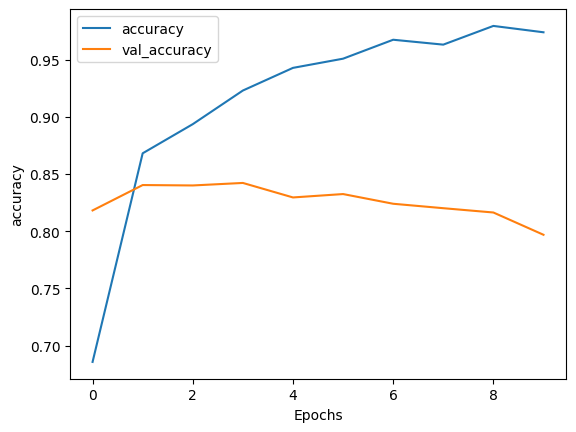

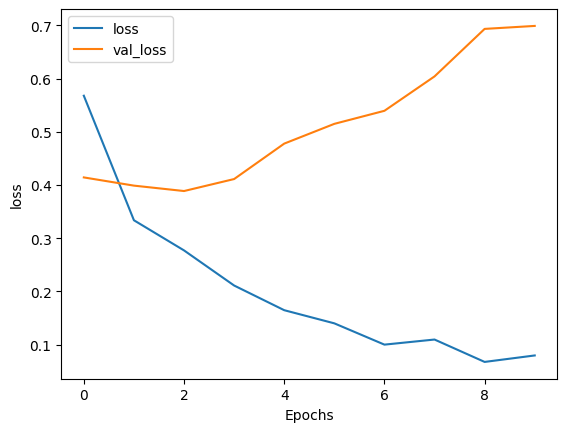

In [11]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Wrap Up

This lab showed how you can build deep networks by stacking LSTM layers. In the next labs, you will continue exploring other architectures you can use to implement your sentiment classification model.